## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)
---

## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7MB 12.8MB/s 
     |████████████████████████████████| 245kB 40.1MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
data = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
data

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
test = data['test']
train = data['train']
val = data['validation']

In [6]:
def get_tweet(data):
    tweet = [x['text'] for x in data]
    labels = [x['label'] for x in data]

    return tweet, labels

In [7]:
tweet, label = get_tweet(train)

In [8]:
tweet[20], label[20]

('i feel irritated and rejected without anyone doing anything or saying anything',
 'anger')

## Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words= 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweet)

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

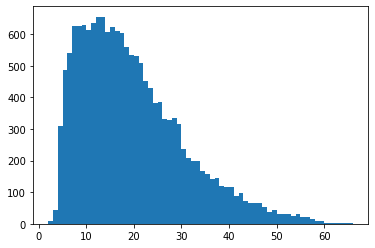

In [11]:
lengths = [len(t.split(' ')) for t in tweet]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [12]:
maxlen = 60
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweet):
    sequences = tokenizer.texts_to_sequences(tweet)
    padded_seq = pad_sequences(sequences, padding= 'post', truncating= 'post', maxlen= maxlen)
    
    return padded_seq

In [13]:
padded_trained_seq = get_sequences(tokenizer, tweet)

In [14]:
padded_trained_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [15]:
classes = set(label)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

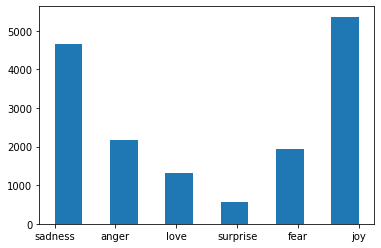

In [16]:
plt.hist(label, bins = 11)
plt.show()

In [17]:
class_to_index = dict((c, i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k,v in class_to_index.items())

In [18]:
print(class_to_index)
print(index_to_class)

{'love': 0, 'joy': 1, 'sadness': 2, 'fear': 3, 'surprise': 4, 'anger': 5}
{0: 'love', 1: 'joy', 2: 'sadness', 3: 'fear', 4: 'surprise', 5: 'anger'}


In [19]:
names_to_ids = lambda label: np.array([class_to_index.get(x) for x in label])

In [20]:
train_labels = names_to_ids(label)
train_labels[0]

2

## Creating the Model

1. Creating the model
2. Compiling the model

In [21]:
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM
from tensorflow.keras.models import Sequential
model = Sequential([
                    Embedding(10000, 16, input_length= maxlen),
                    Bidirectional(LSTM(20, return_sequences= True)),
                    Bidirectional(LSTM(20)),
                    Dense(6, activation= 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [23]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [24]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [26]:
h = model.fit(padded_trained_seq, train_labels, validation_data= (val_seq, val_labels), epochs= 30,
              callbacks= [tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience= 2)]
)

500/500 [==============================] - 34s 67ms/step - loss: 0.1064 - accuracy: 0.9659 - val_loss: 0.4792 - val_accuracy: 0.8705
Epoch 1/30
500/500 [==============================] - 33s 67ms/step - loss: 0.0918 - accuracy: 0.9718 - val_loss: 0.5358 - val_accuracy: 0.8660
Epoch 2/30
500/500 [==============================] - 33s 67ms/step - loss: 0.0884 - accuracy: 0.9718 - val_loss: 0.3966 - val_accuracy: 0.8980
Epoch 3/30
500/500 [==============================] - 33s 67ms/step - loss: 0.0642 - accuracy: 0.9791 - val_loss: 0.4080 - val_accuracy: 0.8870
Epoch 4/30
500/500 [==============================] - 33s 67ms/step - loss: 0.0634 - accuracy: 0.9805 - val_loss: 0.4527 - val_accuracy: 0.8875


## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

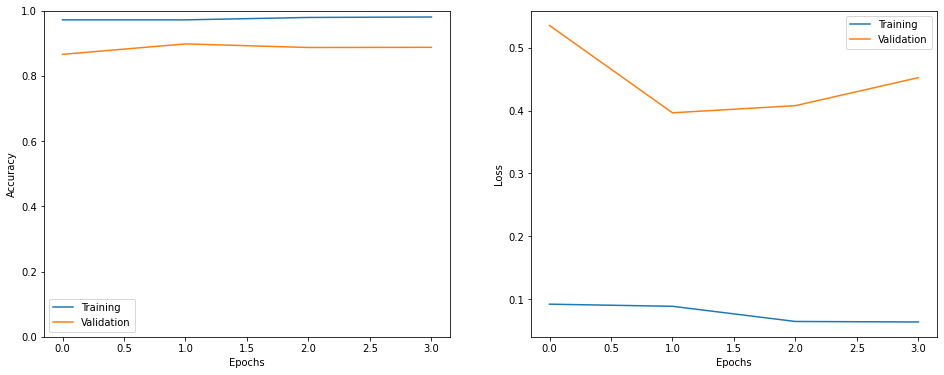

In [27]:
show_history(h)

In [28]:
test_tweets, test_labels = get_tweet(test)
test_seq= get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [37]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 2s 24ms/step - loss: 0.4760 - accuracy: 0.8765


[0.4759957492351532, 0.8765000104904175]

In [33]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis= 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i have been sitting at home revising today and all in all feeling quite stressed
Emotion: anger
Predicted Emotion: anger


In [34]:
preds = model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


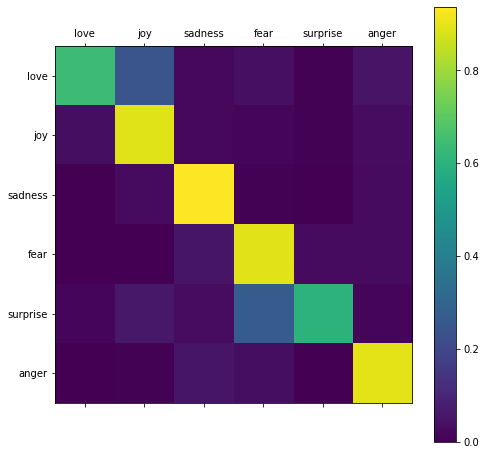

In [35]:
show_confusion_matrix(test_labels, preds, list(classes))

In [36]:
model.save('tweet_emotion.h5')